In [1]:
import pandas as pd
import matplotlib as plt
import sklearn as skl
import tensorflow as tf
import numpy as np
import nltk
import time
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

2023-03-02 09:16:32.432938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
wine_df = pd.read_csv('wine_reviews_with_sentiment.csv',index_col= 'Unnamed: 0')

In [3]:
wine_df

,country,description,designation,points,price,province,region_1,region_2,variety,winery,sentiment
Unnamed: 0,,,,,,,,,,,
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,2.240741e-01
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,3.316667e-01
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1.375000e-01
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1.051948e-01
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,8.888889e-02
...,...,...,...,...,...,...,...,...,...,...,...
281809,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),6.000000e-01
281810,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Pinot Noir,Citation,1.387779e-17
281811,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Gewürztraminer,Domaine Gresser,8.750000e-02


In [4]:
wine_df['region_2'] = wine_df['region_2'].fillna('None')

In [5]:
region_counts = wine_df.region_1.value_counts()
region_counts

Napa Valley                       10726
Columbia Valley (WA)               9118
Russian River Valley               6679
California                         6101
Mendoza                            5898
                                  ...  
Benaco Bresciano                      1
Paso Robles Highlands District        1
Vin Pétillant                         1
Vin de Pays de Côtes du Tarn          1
Monterey County-Napa County           1
Name: region_1, Length: 1332, dtype: int64

<Axes: ylabel='Density'>

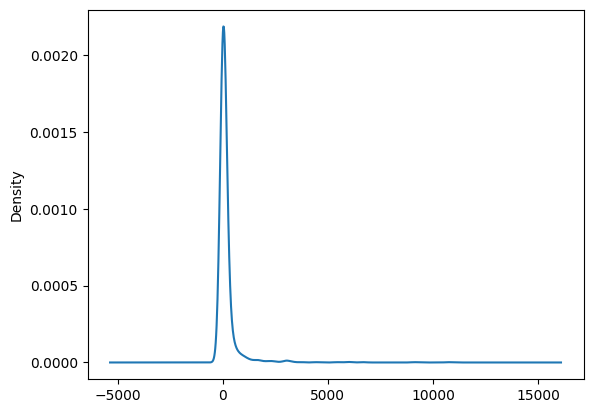

In [6]:
region_counts.plot.density()

In [7]:
region_counts.describe()

count     1332.000000
mean       176.691441
std        637.903257
min          1.000000
25%          5.000000
50%         22.000000
75%         99.250000
max      10726.000000
Name: region_1, dtype: float64

In [8]:
replace_region = list(region_counts[region_counts < 500].index)
replace_region

["Barbera d'Alba",
 'Toro',
 'Pouilly-Fuissé',
 'Arroyo Seco',
 'Eola-Amity Hills',
 'Pomerol',
 'Côtes du Rhône',
 'Barossa',
 'Vino Nobile di Montepulciano',
 'Luján de Cuyo',
 'Saint-Estèphe',
 'Howell Mountain',
 'St. Helena',
 'Etna',
 'Tupungato',
 'Sauternes',
 'Umpqua Valley',
 'Green Valley',
 'Valpolicella Classico Superiore Ripasso',
 'Margaret River',
 'Blaye Côtes de Bordeaux',
 'Saint-Julien',
 'Meursault',
 'Amarone della Valpolicella',
 "Barbera d'Asti",
 'Soave Classico',
 "Montepulciano d'Abruzzo",
 'Jumilla',
 "Vin de Pays d'Oc",
 'Clare Valley',
 'Arroyo Grande Valley',
 'Mount Veeder',
 "Crémant d'Alsace",
 'Beaune',
 'Chianti',
 'Salento',
 'Shenandoah Valley (CA)',
 'Pouilly-Fumé',
 'Veneto',
 'Diamond Mountain District',
 'Valpolicella Superiore Ripasso',
 'Bierzo',
 'Stags Leap District',
 'Prosecco',
 'Cariñena',
 'Campo de Borja',
 'Yarra Valley',
 'Muscadet Sèvre et Maine',
 'Graves',
 'Vin de France',
 'Beaujolais-Villages',
 'Prosecco di Valdobbiadene',
 '

In [9]:
for i in replace_region:
    wine_df.region_1 = wine_df.region_1.replace(i,"Other")

region_counts = wine_df.region_1.value_counts()



<Axes: ylabel='Density'>

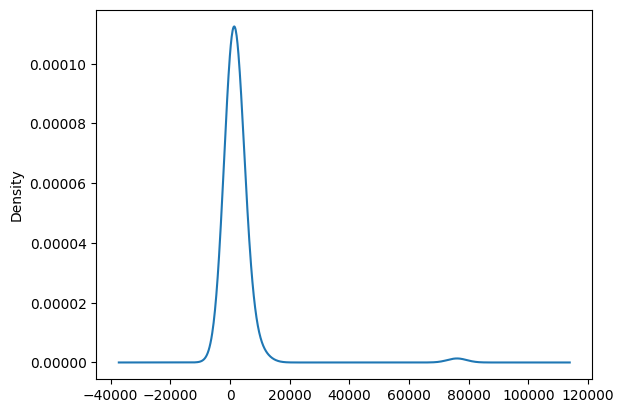

In [10]:
region_counts.plot.density()

In [11]:
winery_counts=wine_df.winery.value_counts()
winery_counts

Williams Selyem          585
Testarossa               495
DFJ Vinhos               473
Chateau Ste. Michelle    420
Wines & Winemakers       392
                        ... 
Namasté Vineyards          1
Finnegan's Lake            1
Villa Yustina              1
Sexual Chocolate           1
Penedo Borges              1
Name: winery, Length: 19186, dtype: int64

<Axes: ylabel='Density'>

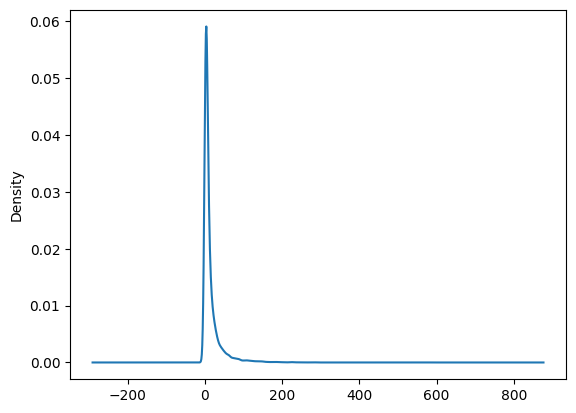

In [12]:
winery_counts.plot.density()

In [13]:
winery_counts.describe()

count    19186.000000
mean        14.688523
std         27.001841
min          1.000000
25%          2.000000
50%          5.000000
75%         15.000000
max        585.000000
Name: winery, dtype: float64

In [14]:
replace_winery = list(winery_counts[winery_counts < 30].index)
replace_winery

['Caldora Vini',
 'Château Kirwan',
 'Château Pichon Longueville Comtesse de Lalande',
 'Château Rahoul',
 'Kaesler',
 'Morgante',
 'Dominio de Atauta',
 'Campelo',
 'Lost Angel',
 'Château Lynch-Bages',
 'Wayfarer',
 'Anne Amie',
 'Belasco de Baquedano',
 'Pope Valley Winery',
 'Tangley Oaks',
 'Nora',
 'Vilafonté',
 'Delamotte',
 'Verbena',
 'Liparita',
 'Calistoga Cellars',
 'Bourassa Vineyards',
 'Langmeil',
 'The Colonial Estate',
 'Heidsieck & Co Monopole',
 'Inception',
 'Cescon Italo Storia e Vini',
 'Château la Gaffelière',
 'Araldica',
 'Estate Constantin Gofas',
 'Vino Con Brio',
 'Brugnano',
 'Carrick',
 'Buitenverwachting',
 'Sacred Hill',
 'Rockroom Winemaking Cooperative',
 'Manzanita Creek',
 'La Valle',
 'Kings Ridge',
 'Musella',
 'Ottimino Vineyards',
 'J. Wilkes',
 'Viñedos y Bodegas Pablo',
 'Cerro Prieto',
 'Huntington',
 'Lanson',
 'Domaine Pommier',
 'Two Angels',
 'Luigi Righetti',
 'Alberti 154',
 'Schwarzböck',
 'Robert Ramsay',
 'Villa Rubini',
 'Domaine de 

In [15]:
for i in replace_winery:
    wine_df.winery = wine_df.winery.replace(i,"Other")

winery_counts = wine_df.winery.value_counts()

In [16]:
winery_counts

Other                    117763
Williams Selyem             585
Testarossa                  495
DFJ Vinhos                  473
Chateau Ste. Michelle       420
                          ...  
Castello del Poggio          30
Fritsch                      30
Domaine Chasselay            30
Sorelle Winery               30
La Folia Winery              30
Name: winery, Length: 2451, dtype: int64

In [17]:
wine_df.dropna(inplace=True)

In [18]:
wine_df = wine_df.drop(columns=['designation'])

In [19]:
# def get_adjectives(text):
#     tokenized = nltk.word_tokenize(str(text)) 
#     tagged = nltk.pos_tag(tokenized)
#     adjectives = [word for word, pos in tagged if pos.startswith('JJ')]
#     return adjectives

In [20]:
# wine_df['adjectives'] = wine_df['description'].apply(get_adjectives)

In [21]:
word_list = ['full bodied','earthy','savory','herbaceous','minerally','toasty','oaky',
             'spicy','flabby','supple','balanced','sweet','aerated','buttery','fruity']

In [22]:
def check_words(row):
    for word in word_list:
        if word in row:
            return word
    return 'none'

In [23]:
wine_df['adjectives'] = wine_df['description'].apply(check_words)

In [24]:
wine_df = wine_df.drop(columns=['description'])

In [25]:
wine_df.tail()

,country,points,price,province,region_1,region_2,variety,winery,sentiment,adjectives
Unnamed: 0,,,,,,,,,,
281802,France,90,57.0,Alsace,Alsace,None,Pinot Gris,Cave de Turckheim,0.216667,none
281805,Italy,90,40.0,Sicily & Sardinia,Sicilia,None,Nero d'Avola,Cusumano,-0.166667,none
281808,France,90,28.0,Alsace,Alsace,None,Pinot Gris,Domaine Rieflé-Landmann,0.223958,none
281811,France,90,30.0,Alsace,Alsace,None,Gewürztraminer,Domaine Gresser,0.087500,fruity
281813,France,90,21.0,Alsace,Alsace,None,Gewürztraminer,Domaine Schoffit,0.191667,none


In [26]:
for col in wine_df:
    print(wine_df[col].dtype)

object
int64
float64
object
object
object
object
object
float64
object


In [27]:
enc = OneHotEncoder(sparse= False)

In [28]:
for col in wine_df:
    if wine_df[col].dtype == 'object':
        enc_col = wine_df[col]
        wine_df = wine_df.drop(columns=col)
        enc_col2 = pd.DataFrame(enc.fit_transform(enc_col.values.reshape(-1,1)))
        enc_col2.columns = enc.get_feature_names([col])
        wine_df = wine_df.merge(enc_col2,left_index=True,right_index=True)
        
        

/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/l

In [29]:
wine_df.head()

,points,price,sentiment,country_Argentina,country_Australia,country_Canada,country_France,country_Italy,country_Spain,country_US,...,adjectives_full bodied,adjectives_herbaceous,adjectives_minerally,adjectives_none,adjectives_oaky,adjectives_savory,adjectives_spicy,adjectives_supple,adjectives_sweet,adjectives_toasty
0,96,235.0,0.224074,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,110.0,0.331667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,96,90.0,0.137500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96,65.0,0.105195,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,95,66.0,0.088889,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
for col in wine_df:
    print(col)

points
price
sentiment
country_Argentina
country_Australia
country_Canada
country_France
country_Italy
country_Spain
country_US
province_Alsace
province_Andalucia
province_Arizona
province_Australia Other
province_Beaujolais
province_Bordeaux
province_British Columbia
province_Burgundy
province_California
province_Canada Other
province_Catalonia
province_Central Italy
province_Central Spain
province_Champagne
province_Colorado
province_Connecticut
province_France Other
province_Galicia
province_Idaho
province_Iowa
province_Italy Other
province_Kentucky
province_Languedoc-Roussillon
province_Levante
province_Loire Valley
province_Lombardy
province_Massachusetts
province_Mendoza Province
province_Michigan
province_Missouri
province_Nevada
province_New Jersey
province_New Mexico
province_New South Wales
province_New York
province_North Carolina
province_Northeastern Italy
province_Northern Spain
province_Northwestern Italy
province_Ohio
province_Ontario
province_Oregon
province_Other
prov

In [31]:
y = wine_df['points']
X = wine_df.drop(columns='points')

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [33]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.fit_transform(X_test)

In [34]:
print(len(X_train_scaled[0]))

1636


In [35]:
number_input_features = len(X_train_scaled[0])
hidden_layers_1 = 750
hidden_layers_list = [250]

nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units=hidden_layers_1, input_dim=number_input_features, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
nn.add(tf.keras.layers.Dropout(0.5))
for i in hidden_layers_list:
    nn.add(tf.keras.layers.Dense(units=i, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    nn.add(tf.keras.layers.Dropout(0.5))

nn.add(tf.keras.layers.Dense(units=1, activation='relu'))





2023-03-02 09:18:12.288709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
checkpoint = ModelCheckpoint('best_weights.h5',save_best_only=True,save_weights_only = True,monitor = 'val_mae',verbose = 1)

In [37]:
nn.compile(loss = 'mae',optimizer ='adam',metrics=['mae'])

In [38]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 750)               1227750   
                                                                 
 dropout (Dropout)           (None, 750)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               187750    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 251       
                                                                 
Total params: 1,415,751
Trainable params: 1,415,751
Non-trainable params: 0
_________________________________________________________________


In [39]:
early_stop = EarlyStopping(monitor='val_mae',patience = 5, verbose = 1)

In [40]:
start_time = time.time()
for i in range(1,82):
    if i >= 60 and i < 72:
        early_stop = EarlyStopping(monitor='val_mae',patience = 3, verbose = 1)
    elif i >= 72:
        early_stop = EarlyStopping(monitor='val_mae',patience = 1, verbose = 1)
    nn.fit(X_train_scaled,y_train,epochs=10000,validation_data=(X_test,y_test),callbacks=[checkpoint,early_stop])
    if i % 2 != 0:
        print(f"loaded Weights {i}")
        nn.load_weights('best_weights.h5')
    else:
        print(f"Random Weights {i}")

end_time = time.time()

Epoch 1/10000
46/50 [==========================>...] - ETA: 0s - loss: 261.8367 - mae: 76.2651
Epoch 1: val_mae improved from inf to 43.78849, saving model to best_weights.h5
50/50 [==============================] - 1s 13ms/step - loss: 250.9417 - mae: 74.9413 - val_loss: 106.9280 - val_mae: 43.7885
Epoch 2/10000
50/50 [==============================] - ETA: 0s - loss: 75.4849 - mae: 20.3276
Epoch 2: val_mae improved from 43.78849 to 31.32539, saving model to best_weights.h5
50/50 [==============================] - 1s 10ms/step - loss: 75.4849 - mae: 20.3276 - val_loss: 79.9195 - val_mae: 31.3254
Epoch 3/10000
47/50 [===========================>..] - ETA: 0s - loss: 59.7871 - mae: 15.3407
Epoch 3: val_mae did not improve from 31.32539
50/50 [==============================] - 0s 9ms/step - loss: 59.5752 - mae: 15.3122 - val_loss: 73.2698 - val_mae: 31.9266
Epoch 4/10000
45/50 [==========================>...] - ETA: 0s - loss: 52.9685 - mae: 14.2623
Epoch 4: val_mae improved from 31.3253

50/50 [==============================] - 0s 9ms/step - loss: 28.6504 - mae: 9.4608 - val_loss: 34.2425 - val_mae: 15.2056
Epoch 12: early stopping
Random Weights 2
Epoch 1/10000
48/50 [===========================>..] - ETA: 0s - loss: 26.3398 - mae: 8.0728
Epoch 1: val_mae did not improve from 7.33981
50/50 [==============================] - 0s 10ms/step - loss: 26.3516 - mae: 8.0970 - val_loss: 38.2286 - val_mae: 20.3722
Epoch 2/10000
46/50 [==========================>...] - ETA: 0s - loss: 25.4852 - mae: 7.9735
Epoch 2: val_mae did not improve from 7.33981
50/50 [==============================] - 0s 8ms/step - loss: 25.4044 - mae: 7.9006 - val_loss: 26.9058 - val_mae: 9.4826
Epoch 3/10000
44/50 [=========================>....] - ETA: 0s - loss: 25.1754 - mae: 8.0424
Epoch 3: val_mae did not improve from 7.33981
50/50 [==============================] - 0s 8ms/step - loss: 25.0809 - mae: 7.9613 - val_loss: 41.9911 - val_mae: 24.9293
Epoch 4/10000
43/50 [========================>.....] 

Epoch 3/10000
45/50 [==========================>...] - ETA: 0s - loss: 18.1131 - mae: 7.1956
Epoch 3: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 18.1624 - mae: 7.2506 - val_loss: 18.6799 - val_mae: 7.7897
Epoch 4/10000
44/50 [=========================>....] - ETA: 0s - loss: 18.1003 - mae: 7.3370
Epoch 4: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 18.2418 - mae: 7.4813 - val_loss: 27.0570 - val_mae: 16.3539
Epoch 5/10000
45/50 [==========================>...] - ETA: 0s - loss: 17.4794 - mae: 7.0456
Epoch 5: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 17.4229 - mae: 7.0018 - val_loss: 18.4146 - val_mae: 8.1227
Epoch 6/10000
49/50 [============================>.] - ETA: 0s - loss: 16.7725 - mae: 6.5859
Epoch 6: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 16.7787 - mae: 6.59

Epoch 8/10000
44/50 [=========================>....] - ETA: 0s - loss: 16.5776 - mae: 6.5933
Epoch 8: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 16.4579 - mae: 6.4550 - val_loss: 18.8706 - val_mae: 8.7020
Epoch 9/10000
44/50 [=========================>....] - ETA: 0s - loss: 16.4648 - mae: 6.6511
Epoch 9: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 9ms/step - loss: 16.4710 - mae: 6.6495 - val_loss: 20.1600 - val_mae: 10.3894
Epoch 10/10000
44/50 [=========================>....] - ETA: 0s - loss: 16.2217 - mae: 6.6167
Epoch 10: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 16.2364 - mae: 6.6027 - val_loss: 15.3960 - val_mae: 5.6236
Epoch 10: early stopping
Random Weights 10
Epoch 1/10000
45/50 [==========================>...] - ETA: 0s - loss: 16.0745 - mae: 6.6868
Epoch 1: val_mae did not improve from 2.06533
50/50 [============================

Epoch 12/10000
47/50 [===========================>..] - ETA: 0s - loss: 14.7651 - mae: 6.8474
Epoch 12: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 14.7958 - mae: 6.8520 - val_loss: 25.3289 - val_mae: 16.9321
Epoch 13/10000
48/50 [===========================>..] - ETA: 0s - loss: 14.7433 - mae: 6.6457
Epoch 13: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 14.7418 - mae: 6.6484 - val_loss: 10.1939 - val_mae: 2.2662
Epoch 14/10000
48/50 [===========================>..] - ETA: 0s - loss: 13.9354 - mae: 6.3842
Epoch 14: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 13.9640 - mae: 6.4260 - val_loss: 12.9816 - val_mae: 5.7675
Epoch 15/10000
50/50 [==============================] - ETA: 0s - loss: 13.6494 - mae: 6.3059
Epoch 15: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 9ms/step - loss: 13.6494 - m

48/50 [===========================>..] - ETA: 0s - loss: 13.5725 - mae: 6.5317
Epoch 12: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 13.5924 - mae: 6.5505 - val_loss: 11.9245 - val_mae: 4.9119
Epoch 13/10000
44/50 [=========================>....] - ETA: 0s - loss: 13.4113 - mae: 6.4950
Epoch 13: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 13.4448 - mae: 6.4965 - val_loss: 13.1191 - val_mae: 5.9177
Epoch 13: early stopping
loaded Weights 15
Epoch 1/10000
44/50 [=========================>....] - ETA: 0s - loss: 19.4656 - mae: 7.0915
Epoch 1: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 9ms/step - loss: 19.6439 - mae: 7.0763 - val_loss: 33.2673 - val_mae: 19.0235
Epoch 2/10000
47/50 [===========================>..] - ETA: 0s - loss: 21.6979 - mae: 7.1438
Epoch 2: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/

45/50 [==========================>...] - ETA: 0s - loss: 14.0832 - mae: 6.8580
Epoch 12: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 14.0319 - mae: 6.8284 - val_loss: 9.8410 - val_mae: 2.8698
Epoch 13/10000
49/50 [============================>.] - ETA: 0s - loss: 13.0686 - mae: 6.2910
Epoch 13: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 13.0662 - mae: 6.2881 - val_loss: 15.2782 - val_mae: 8.5182
Epoch 14/10000
49/50 [============================>.] - ETA: 0s - loss: 12.6380 - mae: 6.1243
Epoch 14: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 8ms/step - loss: 12.6238 - mae: 6.1099 - val_loss: 10.5248 - val_mae: 4.0825
Epoch 15/10000
43/50 [========================>.....] - ETA: 0s - loss: 12.5574 - mae: 6.3843
Epoch 15: val_mae did not improve from 2.06533
50/50 [==============================] - 0s 9ms/step - loss: 12.4758 - mae: 6.2717 - val_

Epoch 5/10000
44/50 [=========================>....] - ETA: 0s - loss: 12.9243 - mae: 6.0793
Epoch 5: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 9ms/step - loss: 12.9728 - mae: 6.1385 - val_loss: 10.6996 - val_mae: 4.0874
Epoch 6/10000
50/50 [==============================] - ETA: 0s - loss: 12.5202 - mae: 6.1763
Epoch 6: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 9ms/step - loss: 12.5202 - mae: 6.1763 - val_loss: 12.6024 - val_mae: 6.4248
Epoch 7/10000
43/50 [========================>.....] - ETA: 0s - loss: 12.4702 - mae: 6.2542
Epoch 7: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 8ms/step - loss: 12.5012 - mae: 6.2603 - val_loss: 10.4194 - val_mae: 4.1577
Epoch 8/10000
45/50 [==========================>...] - ETA: 0s - loss: 12.6072 - mae: 6.5610
Epoch 8: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 8ms/step - loss: 12.5878 - mae: 6.539

loaded Weights 23
Epoch 1/10000
49/50 [============================>.] - ETA: 0s - loss: 14.3347 - mae: 6.6106
Epoch 1: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 8ms/step - loss: 14.3812 - mae: 6.6279 - val_loss: 16.4844 - val_mae: 7.3089
Epoch 2/10000
49/50 [============================>.] - ETA: 0s - loss: 16.0232 - mae: 6.5744
Epoch 2: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 8ms/step - loss: 16.0042 - mae: 6.5521 - val_loss: 26.2296 - val_mae: 16.6350
Epoch 3/10000
48/50 [===========================>..] - ETA: 0s - loss: 15.5781 - mae: 6.4057
Epoch 3: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 8ms/step - loss: 15.5766 - mae: 6.4136 - val_loss: 19.5150 - val_mae: 10.7007
Epoch 4/10000
49/50 [============================>.] - ETA: 0s - loss: 14.8422 - mae: 6.5644
Epoch 4: val_mae did not improve from 1.87827
50/50 [==============================] - 0s 8ms/step - loss: 

Epoch 6/10000
49/50 [============================>.] - ETA: 0s - loss: 9.9801 - mae: 6.2419 
Epoch 6: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 9.9751 - mae: 6.2358 - val_loss: 10.8275 - val_mae: 7.1330
Epoch 7/10000
48/50 [===========================>..] - ETA: 0s - loss: 9.6887 - mae: 6.0065
Epoch 7: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 9.6783 - mae: 5.9963 - val_loss: 6.0853 - val_mae: 2.4563
Epoch 8/10000
49/50 [============================>.] - ETA: 0s - loss: 9.6052 - mae: 6.0996
Epoch 8: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 9.6179 - mae: 6.1153 - val_loss: 12.8314 - val_mae: 9.5495
Epoch 9/10000
49/50 [============================>.] - ETA: 0s - loss: 9.4105 - mae: 6.2695
Epoch 9: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 9.4120 - mae: 6.2711 - val_

48/50 [===========================>..] - ETA: 0s - loss: 13.1240 - mae: 6.2415
Epoch 3: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 13.1075 - mae: 6.2264 - val_loss: 16.0612 - val_mae: 9.3667
Epoch 4/10000
49/50 [============================>.] - ETA: 0s - loss: 12.6933 - mae: 6.2184
Epoch 4: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 12.7012 - mae: 6.2246 - val_loss: 12.2720 - val_mae: 5.8891
Epoch 5/10000
49/50 [============================>.] - ETA: 0s - loss: 12.2405 - mae: 6.3345
Epoch 5: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 12.2598 - mae: 6.3579 - val_loss: 9.3971 - val_mae: 3.7992
Epoch 6/10000
48/50 [===========================>..] - ETA: 0s - loss: 11.4104 - mae: 6.1181
Epoch 6: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 8ms/step - loss: 11.3733 - mae: 6.0888 - val_loss: 7

50/50 [==============================] - 0s 8ms/step - loss: 13.7983 - mae: 6.3730 - val_loss: 15.5605 - val_mae: 8.8725
Epoch 6/10000
43/50 [========================>.....] - ETA: 0s - loss: 12.3699 - mae: 6.1986
Epoch 6: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 9ms/step - loss: 12.3006 - mae: 6.1846 - val_loss: 14.6692 - val_mae: 9.0404
Epoch 6: early stopping
Random Weights 32
Epoch 1/10000
48/50 [===========================>..] - ETA: 0s - loss: 11.5857 - mae: 6.3647
Epoch 1: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 9ms/step - loss: 11.5544 - mae: 6.3446 - val_loss: 12.2171 - val_mae: 7.3820
Epoch 2/10000
50/50 [==============================] - ETA: 0s - loss: 10.8794 - mae: 6.2057
Epoch 2: val_mae did not improve from 1.65440
50/50 [==============================] - 0s 9ms/step - loss: 10.8794 - mae: 6.2057 - val_loss: 8.0983 - val_mae: 3.5476
Epoch 3/10000
44/50 [=========================>....] - ETA

50/50 [==============================] - 0s 8ms/step - loss: 9.7571 - mae: 5.9915 - val_loss: 6.4614 - val_mae: 2.9532
Epoch 3/10000
49/50 [============================>.] - ETA: 0s - loss: 9.8025 - mae: 6.1895
Epoch 3: val_mae did not improve from 1.64532
50/50 [==============================] - 0s 8ms/step - loss: 9.8194 - mae: 6.2073 - val_loss: 5.1007 - val_mae: 1.7017
Epoch 4/10000
49/50 [============================>.] - ETA: 0s - loss: 9.5975 - mae: 6.0222
Epoch 4: val_mae did not improve from 1.64532
50/50 [==============================] - 0s 8ms/step - loss: 9.6073 - mae: 6.0324 - val_loss: 8.1646 - val_mae: 4.7296
Epoch 5/10000
48/50 [===========================>..] - ETA: 0s - loss: 10.2457 - mae: 6.3404
Epoch 5: val_mae did not improve from 1.64532
50/50 [==============================] - 0s 8ms/step - loss: 10.2157 - mae: 6.3137 - val_loss: 5.3784 - val_mae: 1.7837
Epoch 6/10000
49/50 [============================>.] - ETA: 0s - loss: 9.3558 - mae: 6.0706
Epoch 6: val_mae

Epoch 14: early stopping
Random Weights 38
Epoch 1/10000
47/50 [===========================>..] - ETA: 0s - loss: 8.5203 - mae: 5.9504
Epoch 1: val_mae did not improve from 1.64532
50/50 [==============================] - 0s 9ms/step - loss: 8.5709 - mae: 5.9897 - val_loss: 5.2154 - val_mae: 2.5765
Epoch 2/10000
49/50 [============================>.] - ETA: 0s - loss: 8.6789 - mae: 6.0771
Epoch 2: val_mae improved from 1.64532 to 1.63771, saving model to best_weights.h5
50/50 [==============================] - 0s 8ms/step - loss: 8.6626 - mae: 6.0617 - val_loss: 4.0836 - val_mae: 1.6377
Epoch 3/10000
48/50 [===========================>..] - ETA: 0s - loss: 8.4943 - mae: 5.9403
Epoch 3: val_mae did not improve from 1.63771
50/50 [==============================] - 0s 8ms/step - loss: 8.5253 - mae: 5.9683 - val_loss: 4.3122 - val_mae: 1.8567
Epoch 4/10000
49/50 [============================>.] - ETA: 0s - loss: 8.7043 - mae: 6.0099
Epoch 4: val_mae did not improve from 1.63771
50/50 [====

Epoch 3/10000
48/50 [===========================>..] - ETA: 0s - loss: 8.4871 - mae: 6.1169
Epoch 3: val_mae did not improve from 1.63771
50/50 [==============================] - 0s 8ms/step - loss: 8.4513 - mae: 6.0831 - val_loss: 4.4351 - val_mae: 2.3109
Epoch 4/10000
49/50 [============================>.] - ETA: 0s - loss: 8.3990 - mae: 6.0801
Epoch 4: val_mae did not improve from 1.63771
50/50 [==============================] - 0s 8ms/step - loss: 8.3980 - mae: 6.0758 - val_loss: 3.9921 - val_mae: 1.6492
Epoch 5/10000
49/50 [============================>.] - ETA: 0s - loss: 8.6913 - mae: 6.0836
Epoch 5: val_mae did not improve from 1.63771
50/50 [==============================] - 0s 8ms/step - loss: 8.6872 - mae: 6.0768 - val_loss: 4.3548 - val_mae: 1.8081
Epoch 6/10000
48/50 [===========================>..] - ETA: 0s - loss: 8.2855 - mae: 5.9468
Epoch 6: val_mae did not improve from 1.63771
50/50 [==============================] - 0s 8ms/step - loss: 8.2848 - mae: 5.9445 - val_los

46/50 [==========================>...] - ETA: 0s - loss: 8.5301 - mae: 6.0094
Epoch 6: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.5235 - mae: 6.0072 - val_loss: 3.9739 - val_mae: 1.6455
Epoch 7/10000
45/50 [==========================>...] - ETA: 0s - loss: 8.5581 - mae: 6.0050
Epoch 7: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.5653 - mae: 5.9975 - val_loss: 5.0236 - val_mae: 2.4639
Epoch 8/10000
44/50 [=========================>....] - ETA: 0s - loss: 8.8202 - mae: 6.2762
Epoch 8: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 8.8076 - mae: 6.2680 - val_loss: 4.2360 - val_mae: 1.8689
Epoch 9/10000
44/50 [=========================>....] - ETA: 0s - loss: 8.4824 - mae: 6.0626
Epoch 9: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 8.5108 - mae: 6.0948 - val_loss: 4.1049 - va

50/50 [==============================] - 0s 8ms/step - loss: 8.6211 - mae: 6.3095 - val_loss: 4.2464 - val_mae: 2.1172
Epoch 9/10000
45/50 [==========================>...] - ETA: 0s - loss: 8.2100 - mae: 6.0339
Epoch 9: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.1948 - mae: 6.0194 - val_loss: 3.9362 - val_mae: 1.8647
Epoch 10/10000
49/50 [============================>.] - ETA: 0s - loss: 8.1551 - mae: 5.9582
Epoch 10: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.1441 - mae: 5.9475 - val_loss: 4.0531 - val_mae: 2.0422
Epoch 10: early stopping
loaded Weights 49
Epoch 1/10000
48/50 [===========================>..] - ETA: 0s - loss: 9.2375 - mae: 6.1019
Epoch 1: val_mae did not improve from 1.63616
50/50 [==============================] - 1s 10ms/step - loss: 9.2328 - mae: 6.0761 - val_loss: 5.8950 - val_mae: 2.3762
Epoch 2/10000
47/50 [===========================>..] - ETA: 0s -

Epoch 2/10000
48/50 [===========================>..] - ETA: 0s - loss: 9.0152 - mae: 6.0268
Epoch 2: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 9.0045 - mae: 6.0075 - val_loss: 5.0482 - val_mae: 2.0852
Epoch 3/10000
50/50 [==============================] - ETA: 0s - loss: 9.2104 - mae: 6.1837
Epoch 3: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 9.2104 - mae: 6.1837 - val_loss: 5.0403 - val_mae: 2.3396
Epoch 4/10000
44/50 [=========================>....] - ETA: 0s - loss: 8.8523 - mae: 6.2120
Epoch 4: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.7952 - mae: 6.1668 - val_loss: 6.2424 - val_mae: 3.8622
Epoch 5/10000
48/50 [===========================>..] - ETA: 0s - loss: 8.5472 - mae: 6.0693
Epoch 5: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.5806 - mae: 6.0980 - val_los

50/50 [==============================] - ETA: 0s - loss: 10.8028 - mae: 6.0947
Epoch 2: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 10.8028 - mae: 6.0947 - val_loss: 7.2546 - val_mae: 1.9536
Epoch 3/10000
44/50 [=========================>....] - ETA: 0s - loss: 10.7503 - mae: 6.2268
Epoch 3: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 10.5955 - mae: 6.1604 - val_loss: 5.2972 - val_mae: 1.6629
Epoch 4/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.5676 - mae: 5.8279
Epoch 4: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 9.6019 - mae: 5.8756 - val_loss: 5.2799 - val_mae: 1.8321
Epoch 5/10000
44/50 [=========================>....] - ETA: 0s - loss: 9.5044 - mae: 6.0658
Epoch 5: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 9.4774 - mae: 6.0569 - val_loss: 6.0108 

50/50 [==============================] - 0s 8ms/step - loss: 8.3512 - mae: 6.1069 - val_loss: 3.7621 - val_mae: 1.6656
Epoch 11/10000
48/50 [===========================>..] - ETA: 0s - loss: 8.3261 - mae: 6.1440
Epoch 11: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.3240 - mae: 6.1333 - val_loss: 4.0045 - val_mae: 1.7672
Epoch 12/10000
48/50 [===========================>..] - ETA: 0s - loss: 8.3386 - mae: 5.9829
Epoch 12: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.3758 - mae: 6.0152 - val_loss: 3.9779 - val_mae: 1.7285
Epoch 12: early stopping
loaded Weights 59
Epoch 1/10000
49/50 [============================>.] - ETA: 0s - loss: 9.6287 - mae: 6.3184
Epoch 1: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 9.6539 - mae: 6.3357 - val_loss: 7.7735 - val_mae: 4.2607
Epoch 2/10000
49/50 [============================>.] - ETA: 0s 

Epoch 9/10000
47/50 [===========================>..] - ETA: 0s - loss: 8.6955 - mae: 6.1381
Epoch 9: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 8.6926 - mae: 6.1377 - val_loss: 13.6402 - val_mae: 11.3194
Epoch 9: early stopping
loaded Weights 63
Epoch 1/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.1006 - mae: 5.9385
Epoch 1: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 9.0660 - mae: 5.8981 - val_loss: 5.8669 - val_mae: 2.7547
Epoch 2/10000
43/50 [========================>.....] - ETA: 0s - loss: 9.3425 - mae: 5.9490
Epoch 2: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 9.4000 - mae: 5.9813 - val_loss: 5.4262 - val_mae: 2.0411
Epoch 3/10000
49/50 [============================>.] - ETA: 0s - loss: 9.4646 - mae: 6.2057
Epoch 3: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms

48/50 [===========================>..] - ETA: 0s - loss: 9.5822 - mae: 6.2774
Epoch 2: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 9.5679 - mae: 6.2495 - val_loss: 5.7788 - val_mae: 2.3378
Epoch 3/10000
49/50 [============================>.] - ETA: 0s - loss: 9.6687 - mae: 6.0052
Epoch 3: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 9.6667 - mae: 6.0016 - val_loss: 5.1613 - val_mae: 1.6737
Epoch 4/10000
49/50 [============================>.] - ETA: 0s - loss: 9.2371 - mae: 5.9376
Epoch 4: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 8ms/step - loss: 9.2546 - mae: 5.9572 - val_loss: 4.6854 - val_mae: 1.7813
Epoch 4: early stopping
Random Weights 68
Epoch 1/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.0604 - mae: 6.1660
Epoch 1: val_mae did not improve from 1.63616
50/50 [==============================] - 0s 9ms/step - loss: 9.

Epoch 3: early stopping
loaded Weights 73
Epoch 1/10000
49/50 [============================>.] - ETA: 0s - loss: 9.5711 - mae: 6.1245
Epoch 1: val_mae did not improve from 1.62800
50/50 [==============================] - 0s 9ms/step - loss: 9.5563 - mae: 6.1078 - val_loss: 5.2558 - val_mae: 1.9633
Epoch 2/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.1278 - mae: 5.9997
Epoch 2: val_mae did not improve from 1.62800
50/50 [==============================] - 0s 8ms/step - loss: 9.1097 - mae: 5.9725 - val_loss: 4.8872 - val_mae: 1.7675
Epoch 3/10000
49/50 [============================>.] - ETA: 0s - loss: 9.0745 - mae: 6.0311
Epoch 3: val_mae did not improve from 1.62800
50/50 [==============================] - 0s 8ms/step - loss: 9.0894 - mae: 6.0477 - val_loss: 4.3790 - val_mae: 1.6654
Epoch 4/10000
46/50 [==========================>...] - ETA: 0s - loss: 8.9177 - mae: 6.0041
Epoch 4: val_mae did not improve from 1.62800
50/50 [==============================] - 0s 8ms/s

In [41]:
loss,accuracy = nn.evaluate(X_test,y_test)

13/13 [==============================] - 0s 4ms/step - loss: 4.8151 - mae: 1.6280


In [42]:
total_time = end_time - start_time

print(f'{total_time} seconds')

307.1233699321747 seconds


In [43]:
def create_model():
    number_input_features = len(X_train_scaled[0])
    hidden_layers_1 = 750
    hidden_layers_list = [250]

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=hidden_layers_1, input_dim=number_input_features, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    for i in hidden_layers_list:
        model.add(tf.keras.layers.Dense(units=i, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    return model


In [57]:
model_best = create_model()

In [58]:
model_best.load_weights('best_weights.h5')

In [59]:
model_best.compile(loss = 'mae',optimizer ='adam',metrics=['mae'])

In [60]:
loss,accuracy = model_best.evaluate(X_test,y_test)

13/13 [==============================] - 0s 4ms/step - loss: 4.8151 - mae: 1.6280


In [61]:
y_pred = model_best.predict(X_test)

13/13 [==============================] - 0s 3ms/step


In [62]:
data = {'Predicted':y_pred.ravel(),
       'Actual':y_test.ravel()}

In [63]:
result = pd.DataFrame(data)

In [67]:
result['Predicted'] = result['Predicted'].round()

In [71]:
result

,Predicted,Actual
0,91.0,90
1,89.0,89
2,89.0,92
3,90.0,86
4,90.0,90
...,...,...
395,90.0,92
396,90.0,90
397,89.0,90
398,90.0,91


In [72]:
counter = 0
for i in range(len(result)):
    if result['Predicted'].iloc[i] == result['Actual'].iloc[i]:
        counter += 1

print(counter)

        

95


In [73]:
unique_val = result['Predicted'].unique()
print(unique_val)

[ 91.  89.  90.  92.  94. 101.]
